In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load dataset
emi_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/emi_dataset.csv")

# Inspect the data to determine whether the data cleaning is required
print(emi_data.head())
print(emi_data.info())
print(emi_data.describe())

# Check for missing values
print("\nMissing values:\n", emi_data.isnull().sum())

# Separate features(x) and labels(the target variable:y) to prerapre the dataset for the ml model
X = emi_data.drop(columns=["Label"])
y = emi_data['Label']

# Scale numeric features to have the same range (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable to get the unique number of variables and convert them into numerical values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Splitting the dataset into training and testing subsets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Checking class distributions after split to avoid class imbalance(checking whethere stratify has worked properly)
print("\nTraining set class distribution:\n", pd.Series(y_train).value_counts())
print("\nTesting set class distribution:\n", pd.Series(y_test).value_counts())

# Save processed datasets
pd.DataFrame(X_train).to_csv("emi_X_train.csv", index=False)
pd.DataFrame(X_test).to_csv("emi_X_test.csv", index=False)
pd.DataFrame(y_train, columns=['Label']).to_csv("emi_y_train.csv", index=False)
pd.DataFrame(y_test, columns=['Label']).to_csv("emi_y_test.csv", index=False)

print("\n Preprocessing completed and data saved successfully!")


   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   0.000000   0.000099   0.000395   0.000887   0.001575   0.002457   
1  -0.713822  -0.279899   0.482199   0.133958   0.289415   0.277562   
2   0.980843   0.783705   0.572836   0.206571   0.212080   0.403793   
3  -0.617716   0.586457   0.094833  -0.173657   1.187431   0.335691   
4   1.059078   0.686451   0.073678   0.779687   0.335525   0.627093   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_3991  \
0   0.003532   0.004797   0.006250   0.007887  ...      0.007887   
1   0.205903   0.649976  -0.176530   0.650772  ...     -0.381125   
2   1.024948   0.948530   0.513825   0.427782  ...      0.729595   
3   0.752270   0.184754   0.334750   1.192834  ...     -0.075758   
4   0.237534   0.486573   0.232340   0.352916  ...      0.956048   

   Feature_3992  Feature_3993  Feature_3994  Feature_3995  Feature_3996  \
0      0.006250      0.004797      0.003532      0.002457      0.001575   
1     -1.00659

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# Load the EMI dataset
emi_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/emi_dataset.csv")

# Separate features and label (assuming the label column is named "Label")
X = emi_df.drop(columns=["Label"]).values
y = emi_df["Label"].values

# Encode categorical labels into numeric values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for CNN: (samples, time_steps, channels)
# EMI dataset: each sample has 4000 time steps, 1 channel
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split data into train and test sets (80-20 split with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64 #number of samples the model takes at a time
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #the shufffle is set to 'true' to take random rows to understand the variety of patterns. shuffle happens before the batching
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #to make the results consistent it doesnt shuffle the data

# Define a 1D CNN model for EMI classification
class EMICNN(nn.Module): # create a class called EMICNN to interit neural network operations using nn.Module
    def __init__(self, num_classes): #initialize the cnn model(by defining the layers and the structure of the neural network to self(which is an instance) with the number of output classes
        super(EMICNN, self).__init__() #since init method is a method inherited from nn superclas, the super keyword is added in here
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        # After one pooling layer, time steps reduce from 4000 to 2000
        self.fc1 = nn.Linear(128 * (X_train.shape[1] // 2), 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x shape: (batch_size, time_steps, channels)
        # Transpose to (batch_size, channels, time_steps) for Conv1d
        x = x.transpose(1, 2)
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = torch.relu(self.bn2(self.conv2(x)))
        # Flatten for the fully connected layers
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = len(np.unique(y_encoded))
model = EMICNN(num_classes=num_classes)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define class weights (from computed values)
class_weights = [1.5290758, 1.04315789, 0.9979859, 1.90609137, 0.99000999,
                 1.03769634, 0.94832536, 0.94470925, 1.90609137]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define loss function using class weights and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) #calculates the loss funtion for the multi class clasification
optimizer = optim.Adam(model.parameters(), lr=0.0005) #updates the weights for the classes during the training

# Training loop
num_epochs = 55
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []  # Store all predictions
all_labels = []  # Store actual labels

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
test_loss /= total
test_acc = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

#  Ensure that all_preds is not empty before saving
if len(all_preds) > 0:
    emi_predictions = pd.DataFrame({"Predicted_Label": all_preds})
    emi_predictions.to_csv("emi_classification_results.csv", index=False)
    print(" EMI Classification Results Saved Successfully!")
else:
    print(" No predictions found! Something went wrong.")

Epoch 1/55, Loss: 1.7364, Acc: 0.8675
Epoch 2/55, Loss: 0.7097, Acc: 0.8721
Epoch 3/55, Loss: 0.5814, Acc: 0.8820
Epoch 4/55, Loss: 0.5715, Acc: 0.8726
Epoch 5/55, Loss: 0.5221, Acc: 0.8739
Epoch 6/55, Loss: 0.4661, Acc: 0.8780
Epoch 7/55, Loss: 0.4378, Acc: 0.8844
Epoch 8/55, Loss: 0.4444, Acc: 0.8732
Epoch 9/55, Loss: 0.4253, Acc: 0.8749
Epoch 10/55, Loss: 0.4172, Acc: 0.8786
Epoch 11/55, Loss: 0.4984, Acc: 0.8553
Epoch 12/55, Loss: 0.4765, Acc: 0.8499
Epoch 13/55, Loss: 0.4972, Acc: 0.8498
Epoch 14/55, Loss: 0.4513, Acc: 0.8583
Epoch 15/55, Loss: 0.4501, Acc: 0.8667
Epoch 16/55, Loss: 0.4822, Acc: 0.8360
Epoch 17/55, Loss: 0.6171, Acc: 0.7907
Epoch 18/55, Loss: 0.6077, Acc: 0.7900
Epoch 19/55, Loss: 0.6917, Acc: 0.7843
Epoch 20/55, Loss: 0.6403, Acc: 0.8551
Epoch 21/55, Loss: 0.6490, Acc: 0.8452
Epoch 22/55, Loss: 0.6858, Acc: 0.8226
Epoch 23/55, Loss: 0.6787, Acc: 0.8156
Epoch 24/55, Loss: 0.6189, Acc: 0.8129
Epoch 25/55, Loss: 0.6530, Acc: 0.8226
Epoch 26/55, Loss: 0.6757, Acc: 0.

In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

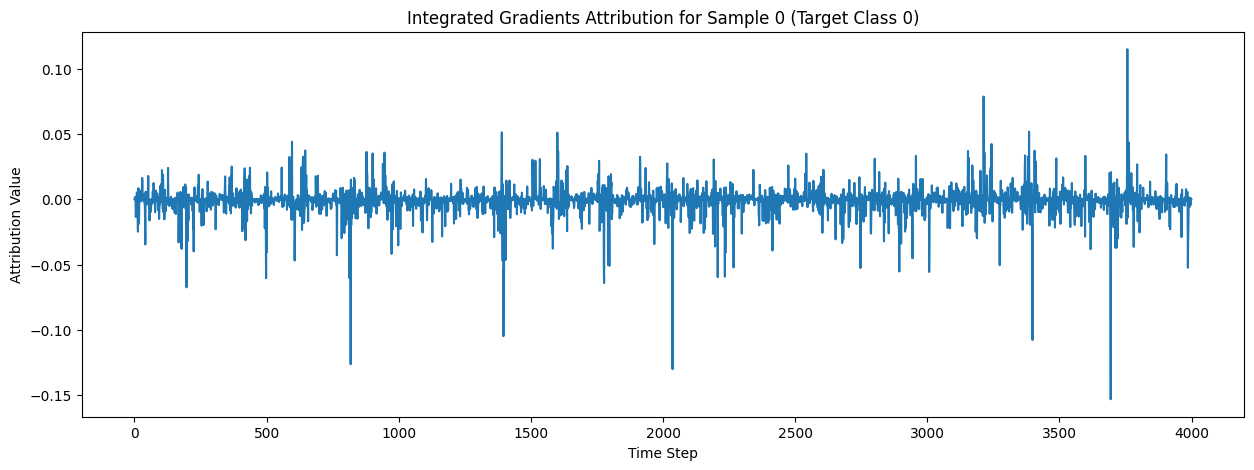

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

# Set device (ensure the model, input sample, and baseline are on the same device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Get a batch of data from the test_loader
inputs, labels = next(iter(test_loader))

# Define test_samples using the inputs from the test_loader
test_samples = inputs

# Move test_samples to the correct device
test_samples = test_samples.to(device)

# Select one sample (as a batch of 1) from test_samples
sample = test_samples[0:1]  # shape: (1, 4000, 1)

# Define a baseline with the same shape as sample (all zeros)
baseline = torch.zeros_like(sample).to(device)

# Create an Integrated Gradients explainer instance
ig = IntegratedGradients(model)

# Compute attributions for the sample with respect to target class 0
attributions, delta = ig.attribute(sample, baseline, target=0, return_convergence_delta=True)

# Squeeze the attributions to remove extra dimensions, resulting in shape (4000,)
attributions_np = attributions.squeeze().cpu().detach().numpy()

# Create feature names for each time step
feature_names = [f"timestep_{i}" for i in range(sample.shape[1])]

# Plot the attributions over time steps
plt.figure(figsize=(15, 5))
plt.plot(np.arange(len(attributions_np)), attributions_np)
plt.xlabel("Time Step")
plt.ylabel("Attribution Value")
plt.title("Integrated Gradients Attribution for Sample 0 (Target Class 0)")
plt.show()

Test Accuracy: 95.83%
Classification Report:
                   precision    recall  f1-score   support

          Arcing       0.97      0.94      0.96       241
          Corona       0.95      0.97      0.96       237
  DataModulation       0.94      0.96      0.95       248
         Exciter       0.98      0.94      0.96       246
   MicroSparking       0.97      0.98      0.97       250
          Normal       0.96      0.94      0.95       239
PartialDischarge       0.95      0.97      0.96       262
    ProcessNoise       0.93      0.96      0.94       262
     RandomNoise       0.98      0.96      0.97       245

        accuracy                           0.96      2230
       macro avg       0.96      0.96      0.96      2230
    weighted avg       0.96      0.96      0.96      2230

Confusion Matrix:
 [[226   4   1   2   0   4   1   2   1]
 [  0 230   0   1   1   0   1   3   1]
 [  1   1 239   0   1   0   2   2   2]
 [  2   0   3 232   2   1   2   4   0]
 [  0   0   1   1 244 

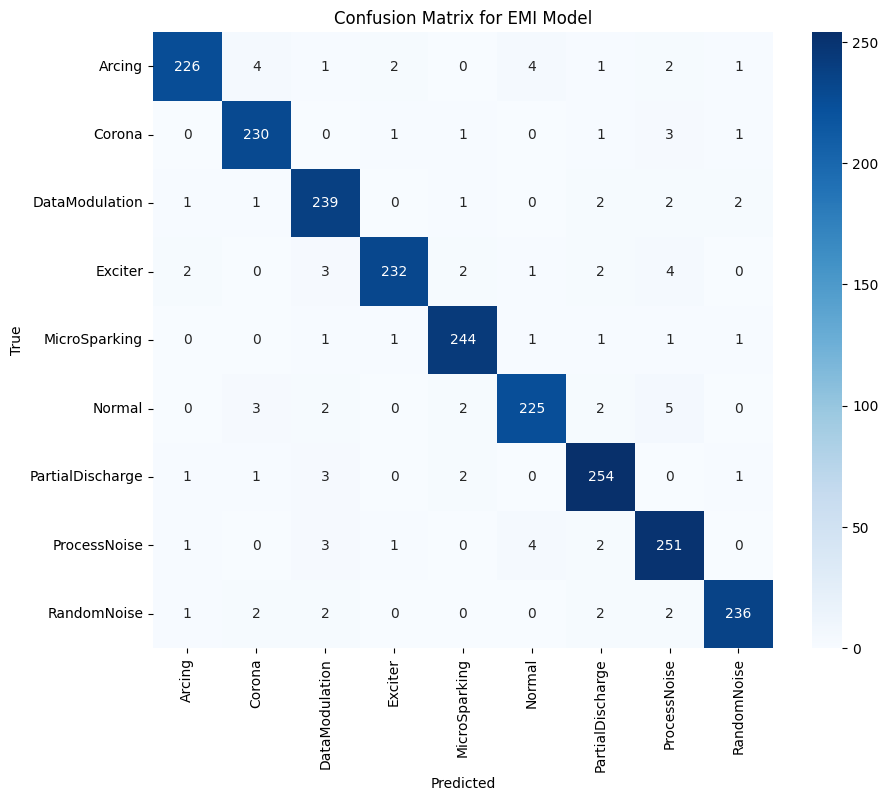

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Collect predictions and true labels from the test_loader
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Generate a classification report (precision, recall, f1-score)
report = classification_report(all_labels, all_preds, target_names=encoder.classes_)
print("Classification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for EMI Model")
plt.show()
